In [5]:
import math,pylab,read_srt
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [6]:
file = np.genfromtxt("raw_offset_data.txt",comments="*",skip_header=1)

az = file[:,1][6:]
el = file[:,2][6:]
offset1, offset2 = file[:,3][6:], file[:,4][6:]
cfq = file[:,5][6:]
spacing = file[:,6][6:]
mode = file[:,7][6:]
channel = file[:,8][6:]
temp = file[:,9:-2][6:]  # don't want the last 2 columns. Must mean over all the values. first 6 rows skipped. 

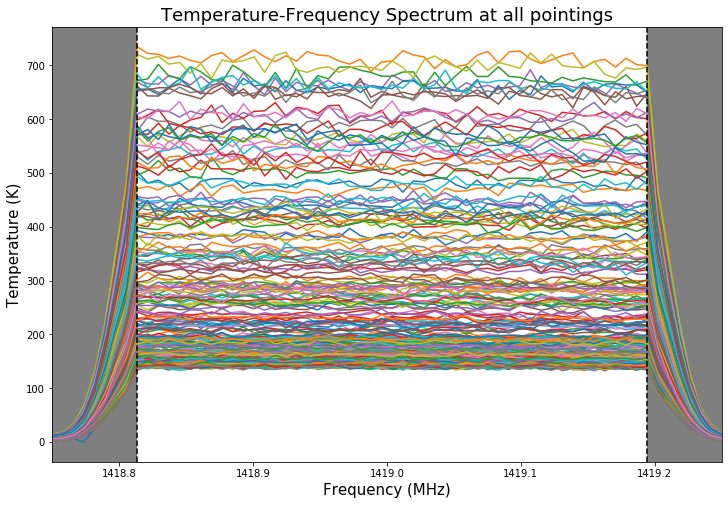

In [7]:
#points = np.arange(6,len(temp[0,:])+6)
#points = np.linspace(cfq[0] - spacing[0]*(len(temp[0,:])/2), cfq[0] + spacing[0]*(len(temp[0,:])/2), len(temp[0,:]))  #1418.75Mhz +/- bandpass
points = np.linspace(cfq[0], cfq[0] + spacing[0]*(len(temp[0,:])), len(temp[0,:]))  #1418.75Mhz +/- bandpass

plt.figure(figsize=(12,8))
for i in range(len(temp)):
    plt.plot(points,temp[i,:])

plt.xlabel("Frequency (MHz)",fontsize=15)
plt.ylabel("Temperature (K)",fontsize=15)
plt.axvline(x=points[8], color = "black", linestyle="--")
plt.axvline(x=points[-8], color = "black", linestyle="--")
plt.axvspan(points[0], points[8], facecolor='k', alpha=0.5)
plt.axvspan(points[-8], points[-1], facecolor='k', alpha=0.5)
plt.xlim([points[0], points[-1]])
plt.title("Temperature-Frequency Spectrum at all pointings",fontsize=18)
plt.savefig("freqSpec.png")

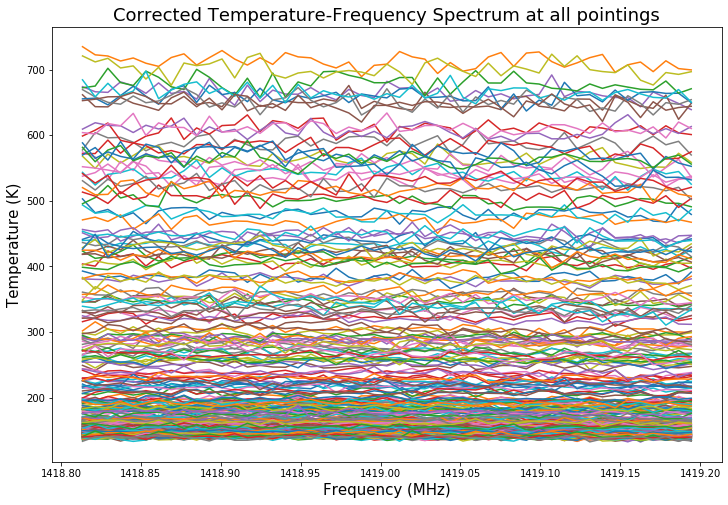

In [9]:
newT = temp[:, 8:-7]
#points = np.arange(0,len(newT[0,:]))
points2 = np.linspace(points[8], points[-8], len(newT[0,:]))  #1420Mhz +/- bandpass


plt.figure(figsize=(12,8))
for i in range(len(newT)):
    plt.plot(points2,newT[i,:])

plt.xlabel("Frequency (MHz)",fontsize=15)
plt.ylabel("Temperature (K)",fontsize=15)
plt.title("Corrected Temperature-Frequency Spectrum at all pointings",fontsize=18)
plt.ticklabel_format(useOffset=False)
plt.savefig("freqSpec2.png")

# Azimuth Scan

In [10]:
off = offset1
meanTemp  = []

for i in range(len(newT)):
    meanTemp.append(np.mean(newT[i]))

result = []
maxT = []

iteri = np.arange(-7,14)  # non-duplicate offsets

for j in iteri:
    for i in range(len(off)):
        if (off[i]==j):
            result.append(meanTemp[i])
    
    if j==8:
        result[np.argmax(result)] = 0
        #print(result)
    if j == 13:
        result[-1], result[-2], result[-3], result[-4] = 0,0,0,0
        #print(result)
    maxT.append(max(result))  # these max are the closest to the sun.
    result = []

In [11]:
stdMean  = []

for i in range(len(newT)):
    stdMean.append(np.std(newT[i]))  # standard deviation of each row

allStds = []

for j in iteri:
    for i in range(len(off)):
        if (off[i]==j):
            allStds.append(stdMean[i])  # standard deviation corresponding to each offset

maxStd = []

for i in range(len(maxT)):
    ind = meanTemp.index(maxT[i])
    maxStd.append(allStds[ind])  # stds corresponding to max temperatures. 

(array([578.42792798,   2.40394458,   2.43234796, 135.54019537]),
 array([7.34992044, 0.02852543, 0.04494403, 6.05027297]))

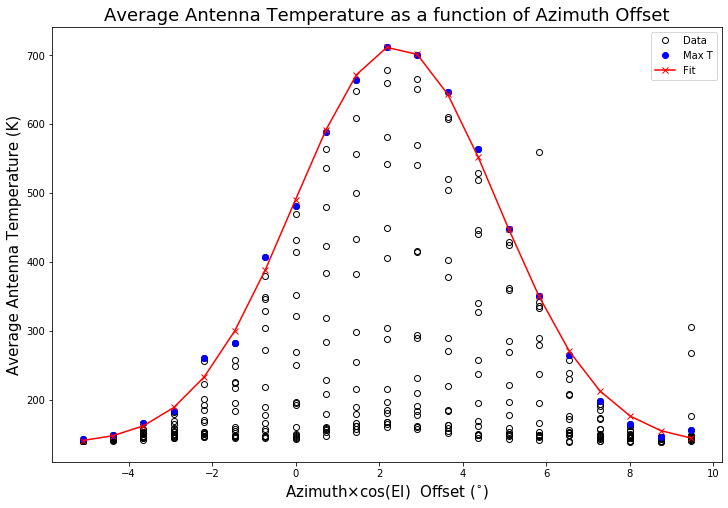

In [12]:
def gauss(xval, amp, cent1, sigma1, c):
    return amp*np.exp(-(xval-cent1)**2/(2*sigma1**2)) + c

maxEl = np.cos(43.2*np.pi/180)
popt, pcov = curve_fit(gauss, iteri*maxEl, maxT, p0=[600, np.mean(newT), np.std(newT), 113])#,sigma=maxStd)

plt.figure(figsize=(12,8))
plt.plot(off*maxEl, meanTemp,'ko',markerfacecolor='none',label="Data")
plt.plot(iteri*maxEl, maxT, "bo", label="Max T")
plt.plot(iteri*maxEl,gauss(iteri*maxEl, *popt), "rx-",label='Fit')
plt.xlabel(r"Azimuth$\times$cos(El)  Offset $(^{\circ})$",fontsize=15)
plt.ylabel("Average Antenna Temperature (K)",fontsize=15)
plt.title("Average Antenna Temperature as a function of Azimuth Offset",fontsize=18)
plt.legend()
plt.savefig("azScan.png")

errors = np.sqrt(np.diag(pcov))

popt, errors

Beam Width: 5.757 degrees
Beam Width via Gaussian Distribution: 5.728 degrees


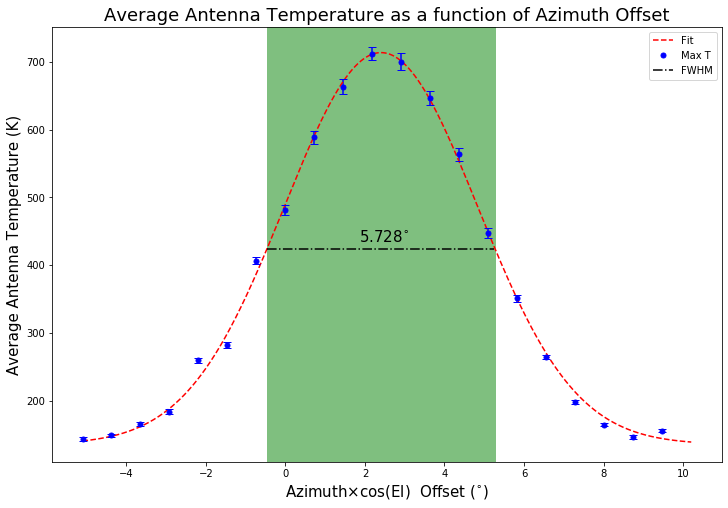

In [13]:
iteri3 = np.linspace(-7,14,1000)  # non-duplicate offsets
model = gauss(iteri3*maxEl, *popt)
halfMax = (max(maxT)+popt[-1])/2
r1, r2 = 5.29007, -0.466446
FWHM = r1-r2
FWHMgauss = 2*popt[2]*np.sqrt(2*np.log(2))#2.355*abs(popt2[2])
xtick = [-7,-5,-3,-1,1,3,5,7,9,11,13]

textstr = r'$%.3f$$^{\circ}$' % (FWHMgauss)

#'%$^{\circ}$' % (FWHMgauss)

plt.figure(figsize=(12,8))
plt.plot(iteri3*maxEl, model, "r--", markersize=1.5, label='Fit')
plt.plot(iteri*maxEl, maxT, "bo", markersize=5, label="Max T")
plt.errorbar(iteri*maxEl, maxT, yerr = maxStd, capsize=4, fmt=' ', color='b')                              
plt.axvspan(r1, r2, facecolor='g', alpha=0.5)
plt.axhline(y=halfMax, xmin=0.321, xmax=0.66, color = "black", linestyle="-.",label="FWHM")
plt.xlabel(r"Azimuth$\times$cos(El)  Offset $(^{\circ})$",fontsize=15)
#plt.xticks(ticks=xtick)
plt.ylabel("Average Antenna Temperature (K)",fontsize=15)
plt.title("Average Antenna Temperature as a function of Azimuth Offset",fontsize=18)
plt.text(1.85, halfMax+10, textstr,fontsize=15)
plt.legend()
plt.savefig("azScanFinal.png")

print(r"Beam Width: {:.3f} degrees".format(FWHM))
print(r"Beam Width via Gaussian Distribution: {:.3f} degrees".format(FWHMgauss))

In [14]:
lamb = (3E8)/(1419.0E6) # 1419
kb = 1.38E-23
antTemp = ((popt[0])*2) #(max(maxT) - popt[-1])*2    # multiplied by 2 because 1 polarization halves incoming E and T. 
# divided by 0.7 to account for efficiency. 

sunSA = np.pi*(6.957E8)**2/(1.496E11)**2  # sun solid angle as seen from earth
beamSA = 1.13309*((FWHMgauss*(np.pi/180)))**2

Tb = (beamSA/sunSA)*(antTemp)
fluxDens = ((2*kb*sunSA*Tb)/(lamb**2))/((1E4*1E-26)) # same as switching sunSA for beamSA and Tb for Ta

print("Antenna Temperature: {:.3f} K".format(antTemp))
print("Brightness Temperature: {:.7f} K".format(Tb))
print("Flux Density: {:.7f} sfu".format(fluxDens)) 

Antenna Temperature: 1156.856 K
Brightness Temperature: 192812.2197422 K
Flux Density: 80.8903306 sfu


The best-fit parameters obtained by the fitting in Figure 6 are: $A_2$ = 578.428$\pm$7.350, $\mu_2$ = 2.404$\pm$0.029, $\sigma_2$ = 2.432$\pm$0.045, and $C_2$ = 135.540$\pm$6.050.

# Elevation Scan

In [15]:
off2 = offset2

meanTemp2  = []

for i in range(len(newT)):
    meanTemp2.append(np.mean(newT[i]))

iteri2 = np.asarray(-0.2)  
offEl = np.append(iteri2, np.arange(0.8,16.8)) # non-duplicate offsets

result2 = []
maxT2 = []

for j in offEl:
    for i in range(len(off2)):
        if (off2[i]==j):
            result2.append(meanTemp2[i])
    
    if j==13.8:
        result2[np.argmax(result2)] = 0
        #print(result2)
#     if j == 15.8:
#         result2[-1], result2[-2], result2[-3], result2[-4] = 0,0,0,0
#         print(result2)
    maxT2.append(max(result2))  # these max are the closest to the sun.
    result2 = []

In [16]:
stdMean2  = []

for i in range(len(newT)):
    stdMean2.append(np.std(newT[i]))  # standard deviation of each row. same as stdMean

allStds2 = []

for j in offEl:
    for i in range(len(off2)):
        if (off2[i]==j):
            allStds2.append(stdMean2[i])  # standard deviation corresponding to each offset

maxStd2 = []

for i in range(len(maxT2)):
    ind2 = meanTemp2.index(maxT2[i])
    maxStd2.append(allStds2[ind2])  # stds corresponding to max temperatures.

(array([542.26634722,   9.93804139,   2.4140102 , 173.77691655]),
 array([7.36421994, 0.03279651, 0.04410436, 4.94418242]))

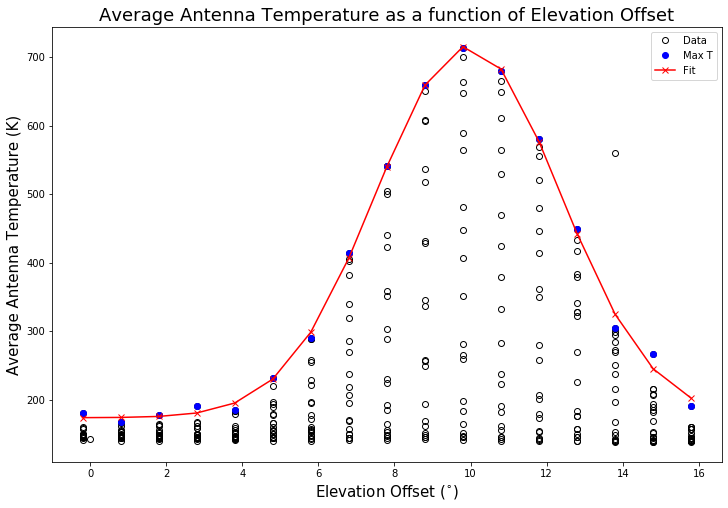

In [17]:
popt2, pcov2 = curve_fit(gauss, offEl, maxT2, p0=[600, np.mean(newT), np.std(newT), 200])#, sigma=maxStd2)

plt.figure(figsize=(12,8))
plt.plot(off2, meanTemp2,'ko',markerfacecolor='none',label="Data")
plt.plot(offEl, maxT2, "bo", label="Max T")
plt.plot(offEl,gauss(offEl, *popt2), "rx-",label='Fit')
plt.xlabel("Elevation Offset $(^{\circ})$",fontsize=15)
plt.ylabel("Average Antenna Temperature (K)",fontsize=15)
plt.title("Average Antenna Temperature as a function of Elevation Offset",fontsize=18)
plt.legend()
plt.savefig("elScan.png")


errors2 = np.sqrt(np.diag(pcov2))

popt2, errors2

Beam Width: 5.711 degrees
Beam Width via Gaussian Distribution: 5.685 degrees


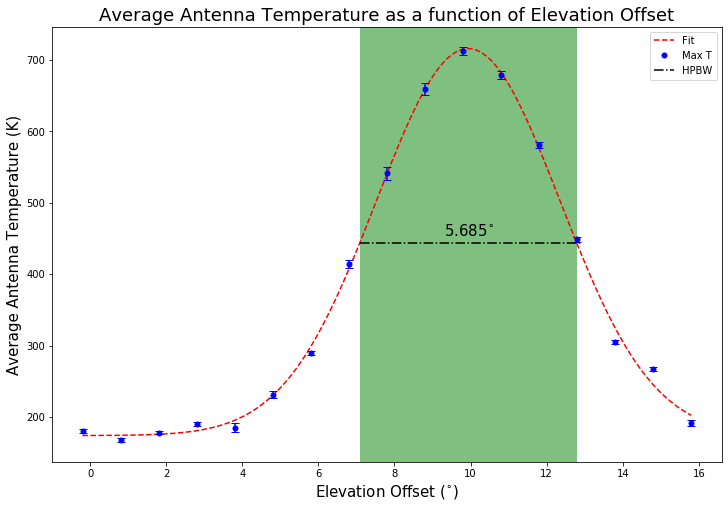

In [18]:
iteri3 = np.linspace(-0.2,15.8,1000)  # non-duplicate offsets
model = gauss(iteri3, *popt2)
halfMax2 = (max(maxT2)+popt2[-1])/2
r1, r2 = 12.7935, 7.08261
FWHM2 = r1-r2
FWHMgauss2 = 2*popt2[2]*np.sqrt(2*np.log(2))#2.355*abs(popt2[2])
#xtick = [-7,-5,-3,-1,1,3,5,7,9,11,13]
textstr2 = r'$%.3f$$^{\circ}$' % (FWHMgauss2)

plt.figure(figsize=(12,8))
plt.plot(iteri3, model, "r--", markersize=1.5, label='Fit')
plt.plot(offEl, maxT2, "bo", markersize=5, label="Max T")
plt.errorbar(offEl, maxT2, yerr = maxStd2, capsize=4, fmt=' ', color='b')                              
plt.axvspan(r1, r2, facecolor='g', alpha=0.5)
plt.axhline(y=halfMax2, xmin = 0.46, xmax=0.79, color = "black", linestyle="-.",label="HPBW")
plt.xlabel("Elevation Offset $(^{\circ})$",fontsize=15)
#plt.xticks(ticks=xtick)
plt.text(9.3, halfMax2+10, textstr2,fontsize=15)
plt.ylabel("Average Antenna Temperature (K)",fontsize=15)
plt.title("Average Antenna Temperature as a function of Elevation Offset",fontsize=18)
plt.legend()
plt.savefig("elScanFinal.png")
print(r"Beam Width: {:.3f} degrees".format(FWHM2))
print(r"Beam Width via Gaussian Distribution: {:.3f} degrees".format(FWHMgauss2))

In [19]:
antTemp2 = ((popt2[0])*2) #(max(maxT2) - popt2[-1])*2    # multiplied by 2 because 1 polarization halves incoming E and T. 

beamSA2 = 1.13309*((FWHMgauss2*(np.pi/180)))**2

Tb2 = (beamSA2/sunSA)*(antTemp2)#/0.7
fluxDens2 = ((2*kb*sunSA*Tb2)/(lamb**2))/((1E4*1E-26)) # same as switching sunSA for beamSA and Tb for Ta

print("Antenna Temperature: {:.3f} K".format(antTemp2))
print("Brightness Temperature: {:.3f} K".format(Tb2))
print("Flux Density: {:.3f} sfu".format(fluxDens2)) 

Antenna Temperature: 1084.533 K
Brightness Temperature: 178042.937 K
Flux Density: 74.694 sfu


The best-fit parameters obtained by the fitting in Figure 4 are: $A_1$ = 542.266$\pm$7.364, $\mu_1$ = 9.938$\pm$0.033, $\sigma_1$ = 2.414$\pm$0.044, and $C_1$ = 173.777$\pm$4.944. 